Step 0:


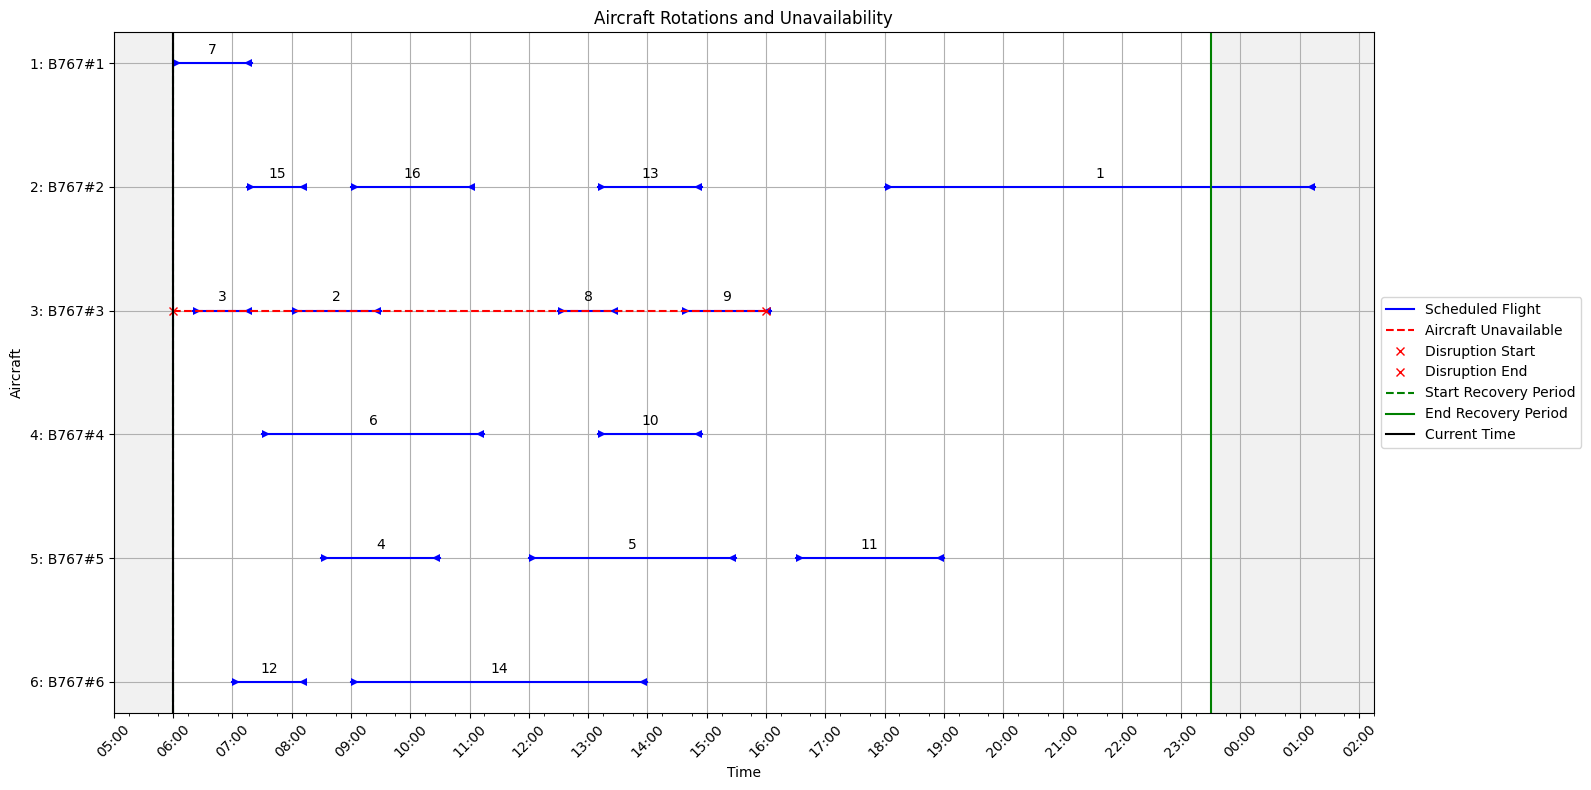

Action taken: [5], Reward: [1000.]
Step 1:


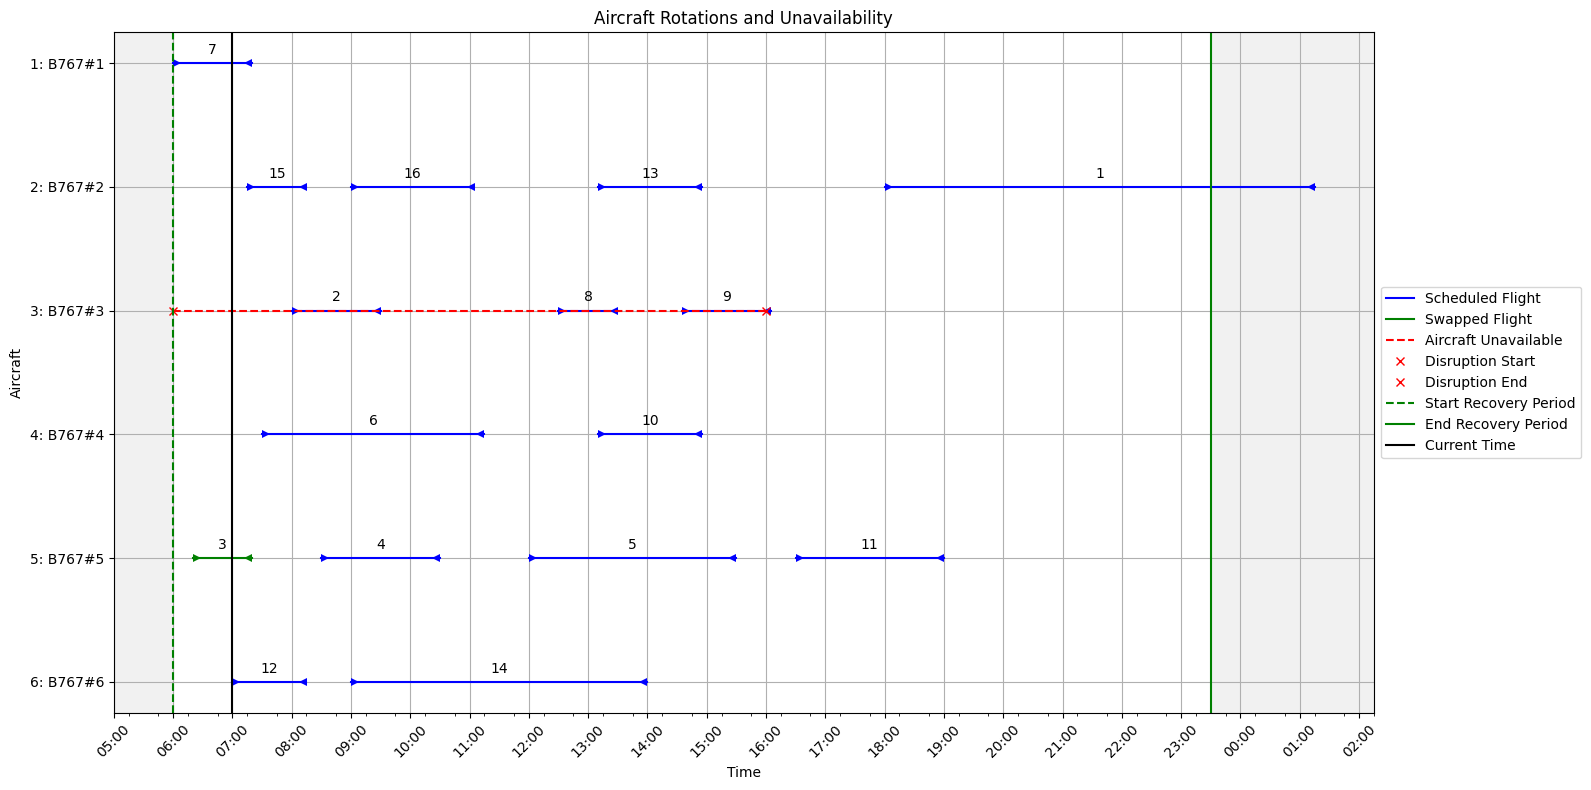

Action taken: [5], Reward: [5700.]
Step 2:


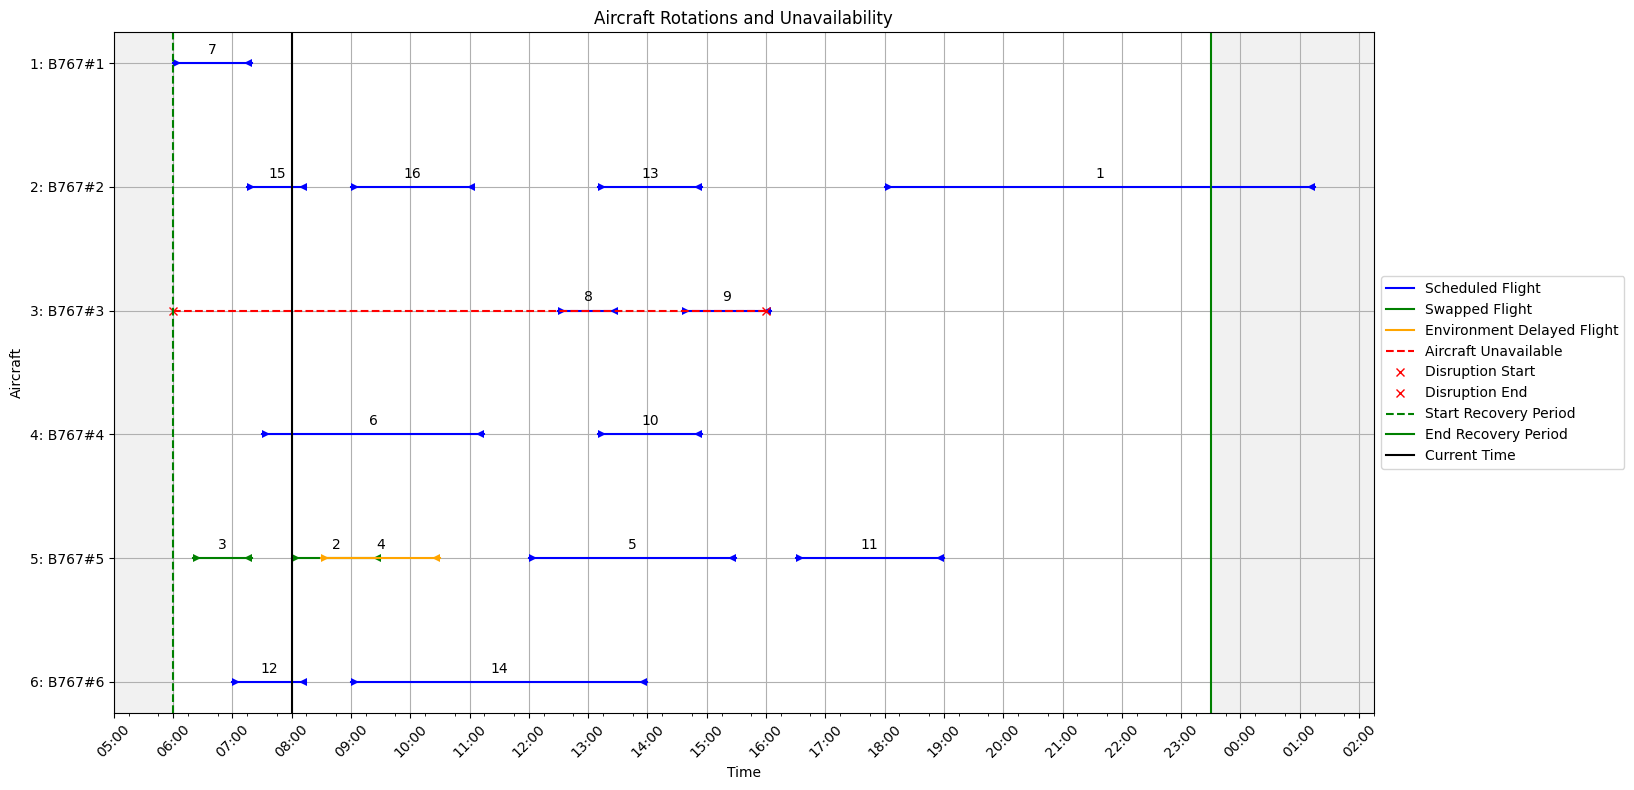

Action taken: [5], Reward: [5400.]
Step 3:


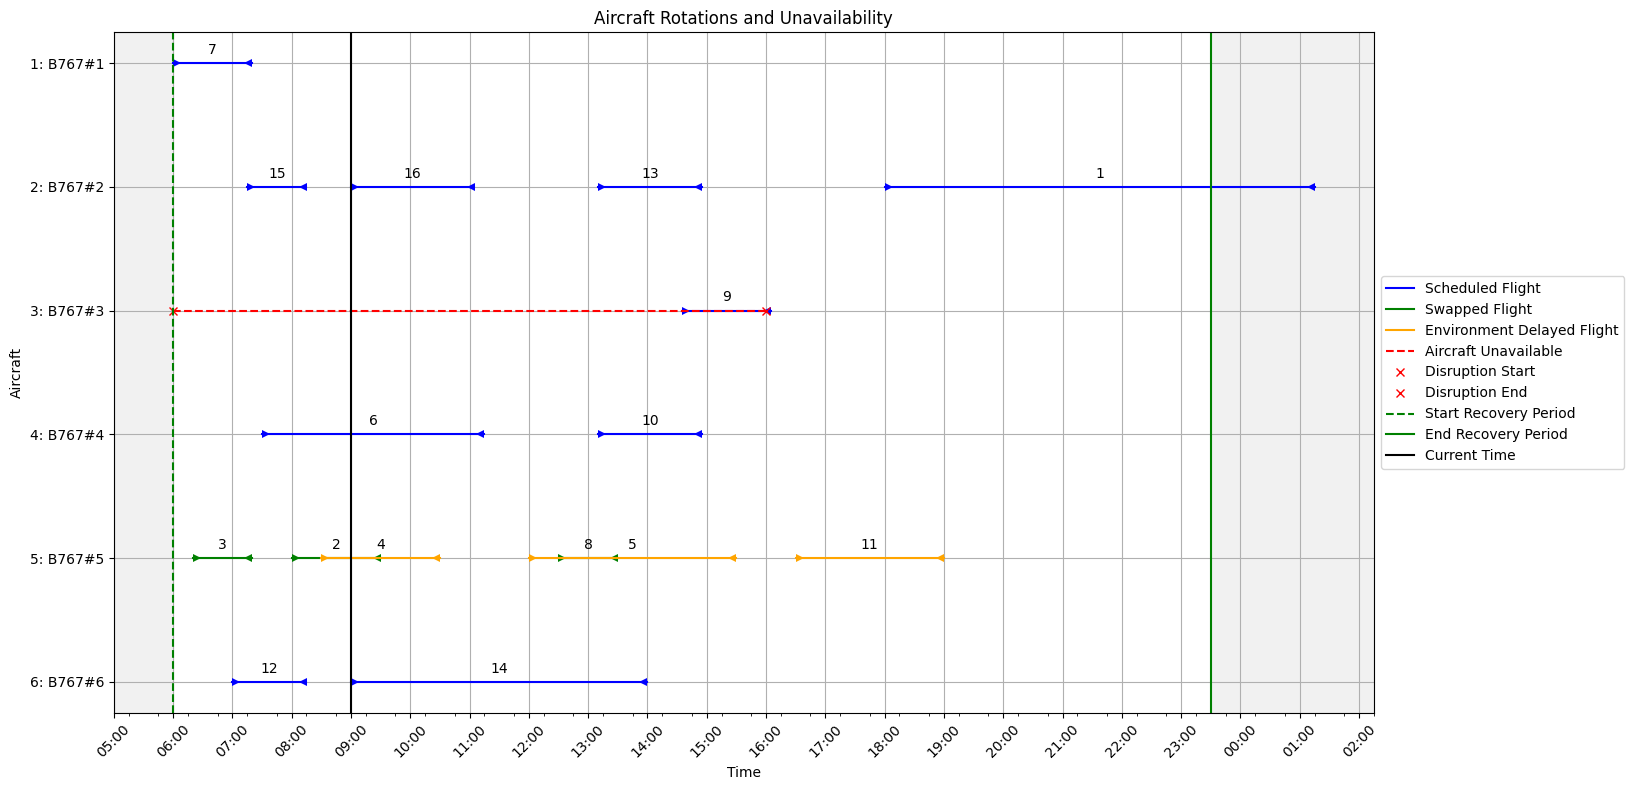

Action taken: [5], Reward: [4275.]
Step 4:


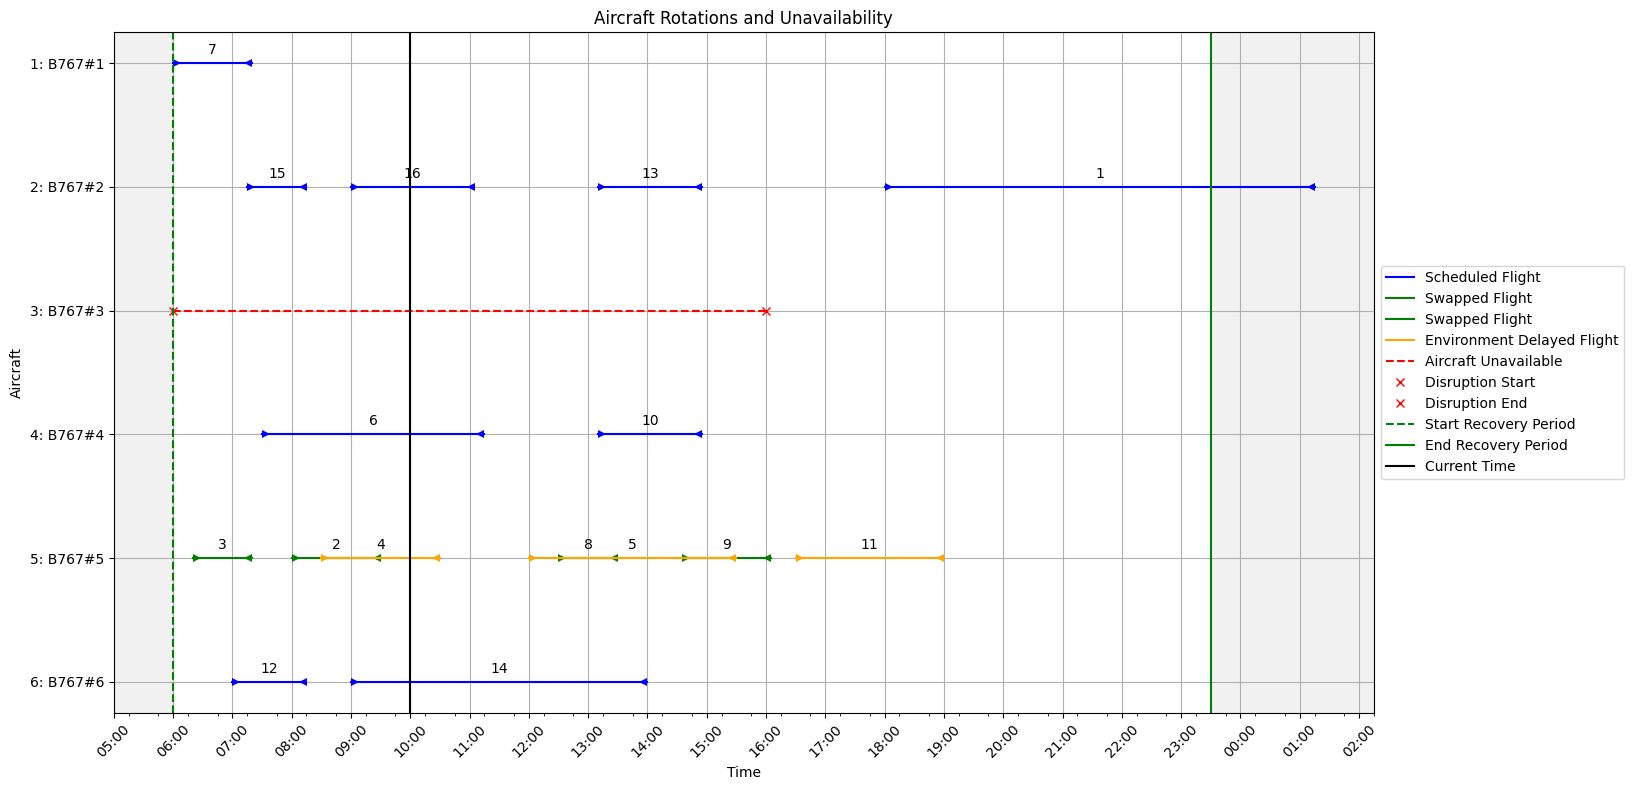

Action taken: [5], Reward: [0.]
Step 5:


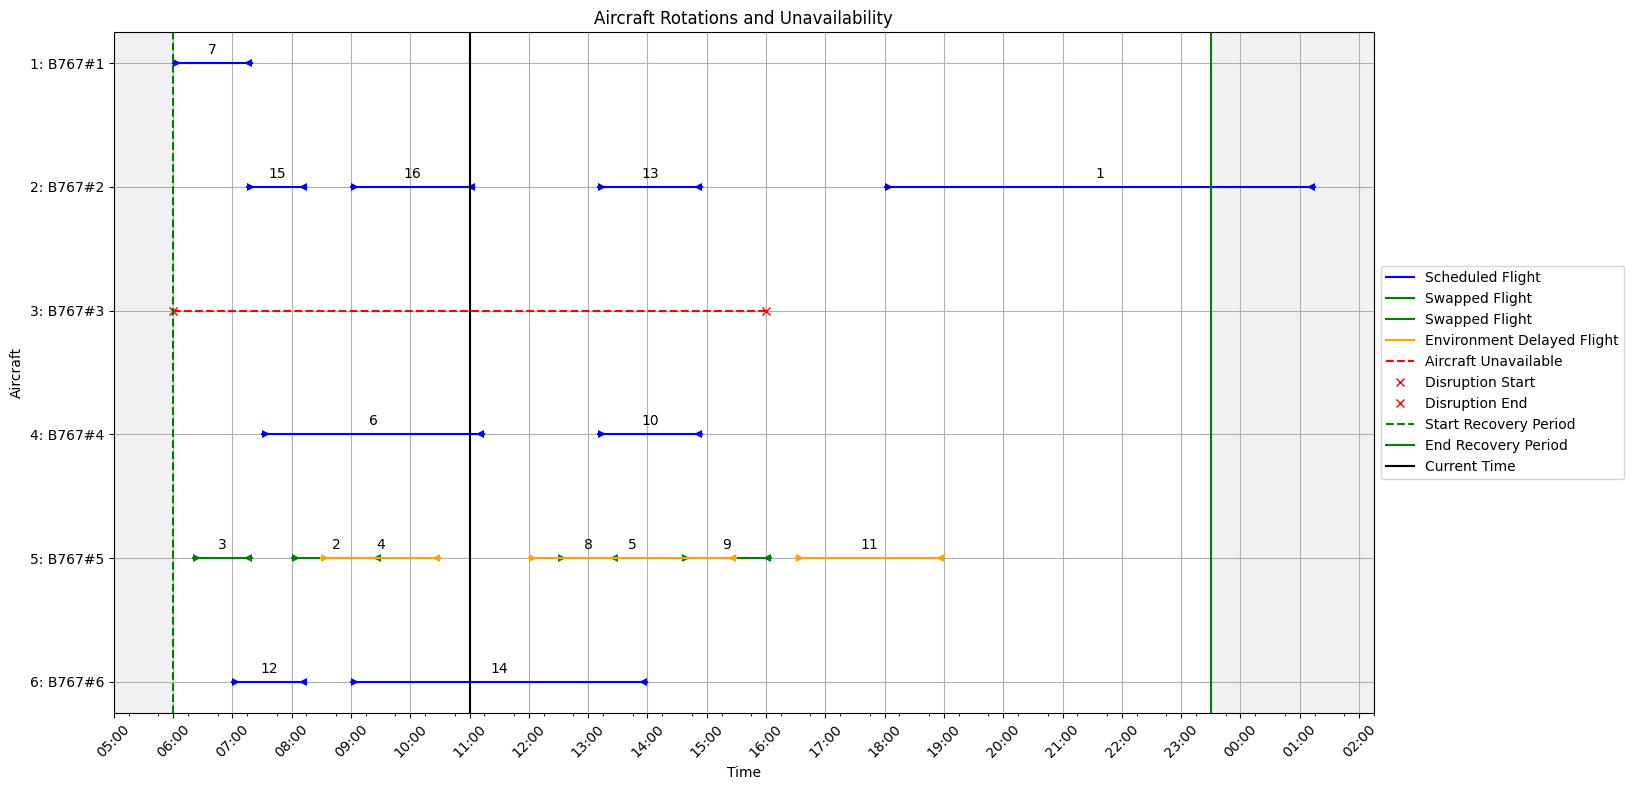

Action taken: [5], Reward: [0.]
Step 6:


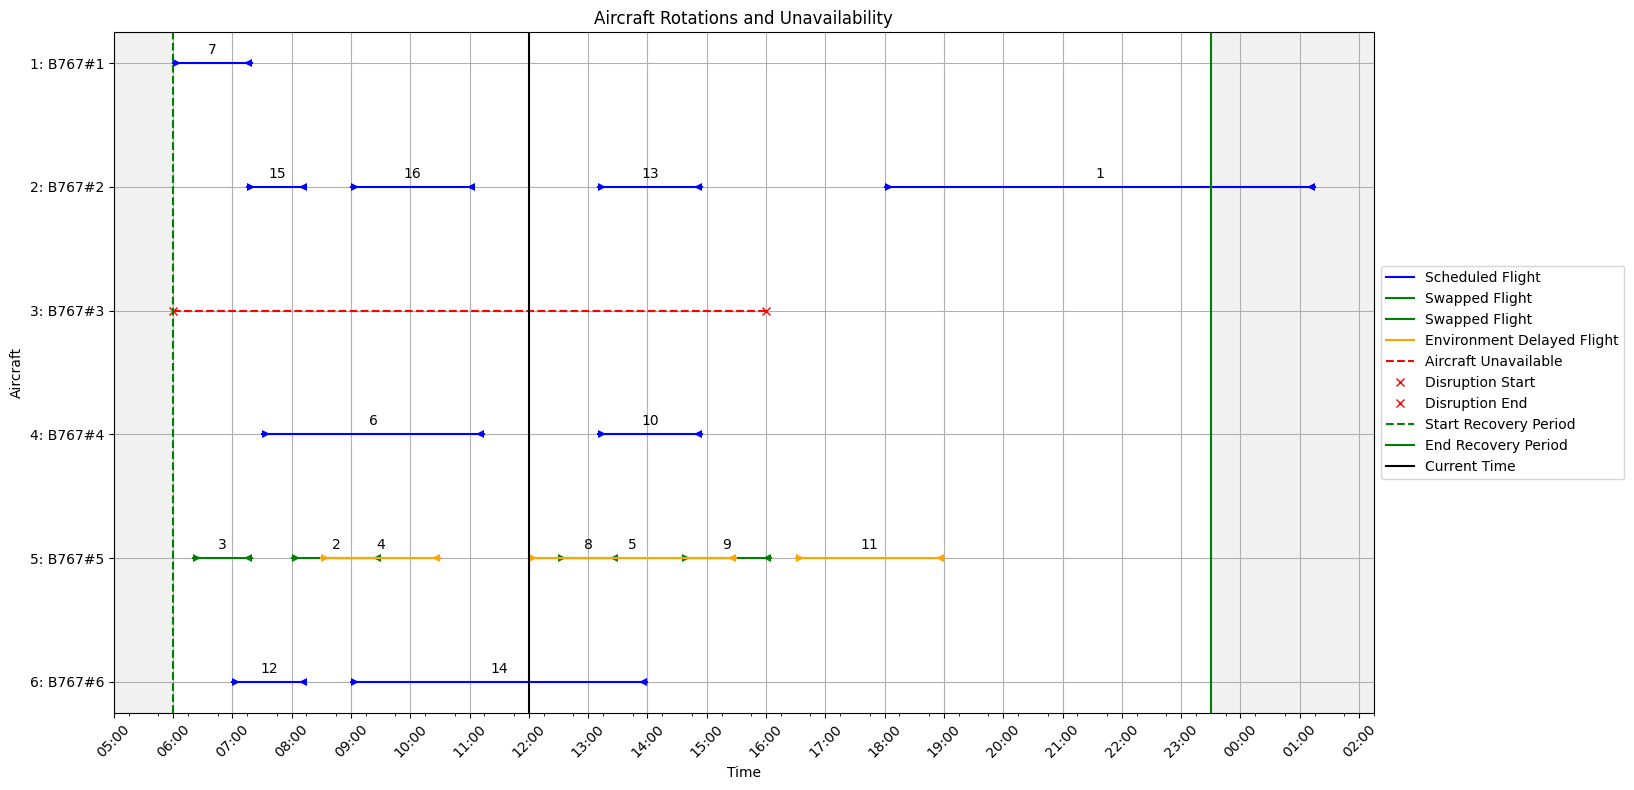

Action taken: [5], Reward: [0.]
Step 7:


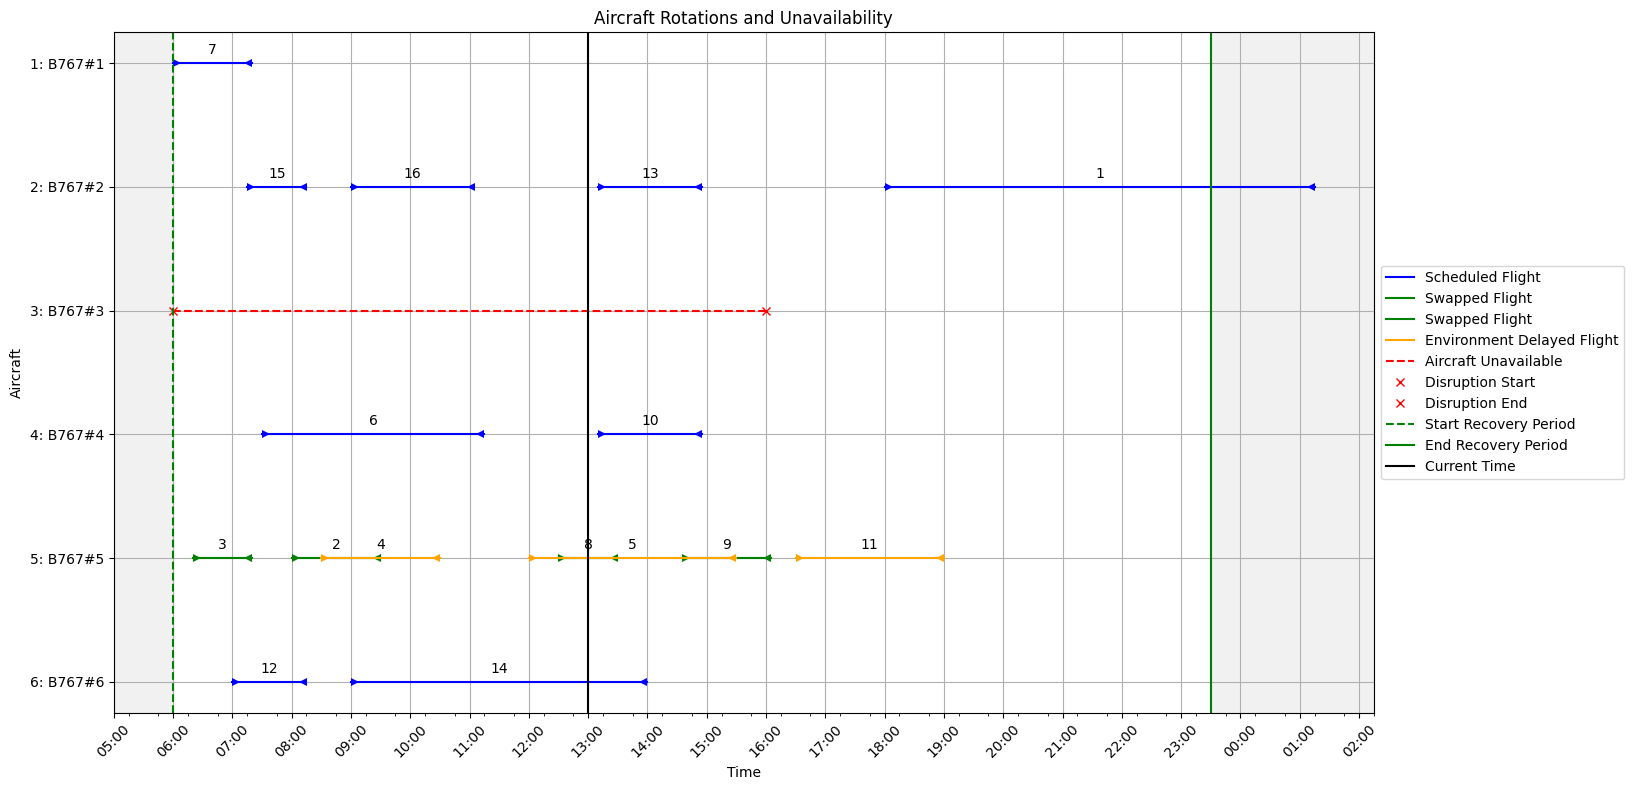

Action taken: [5], Reward: [0.]
Step 8:


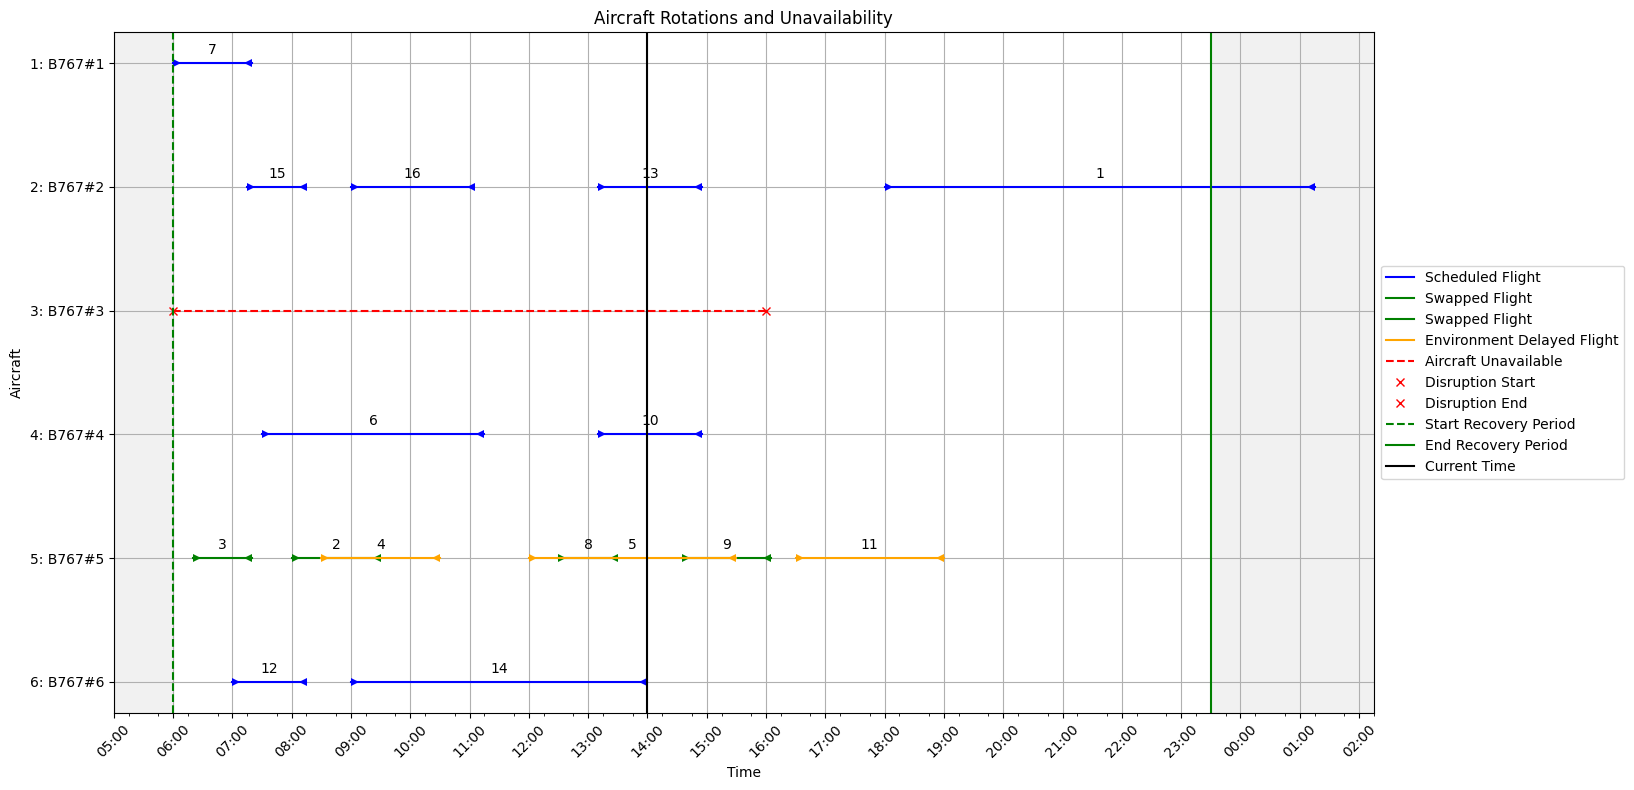

Action taken: [5], Reward: [0.]
Step 9:


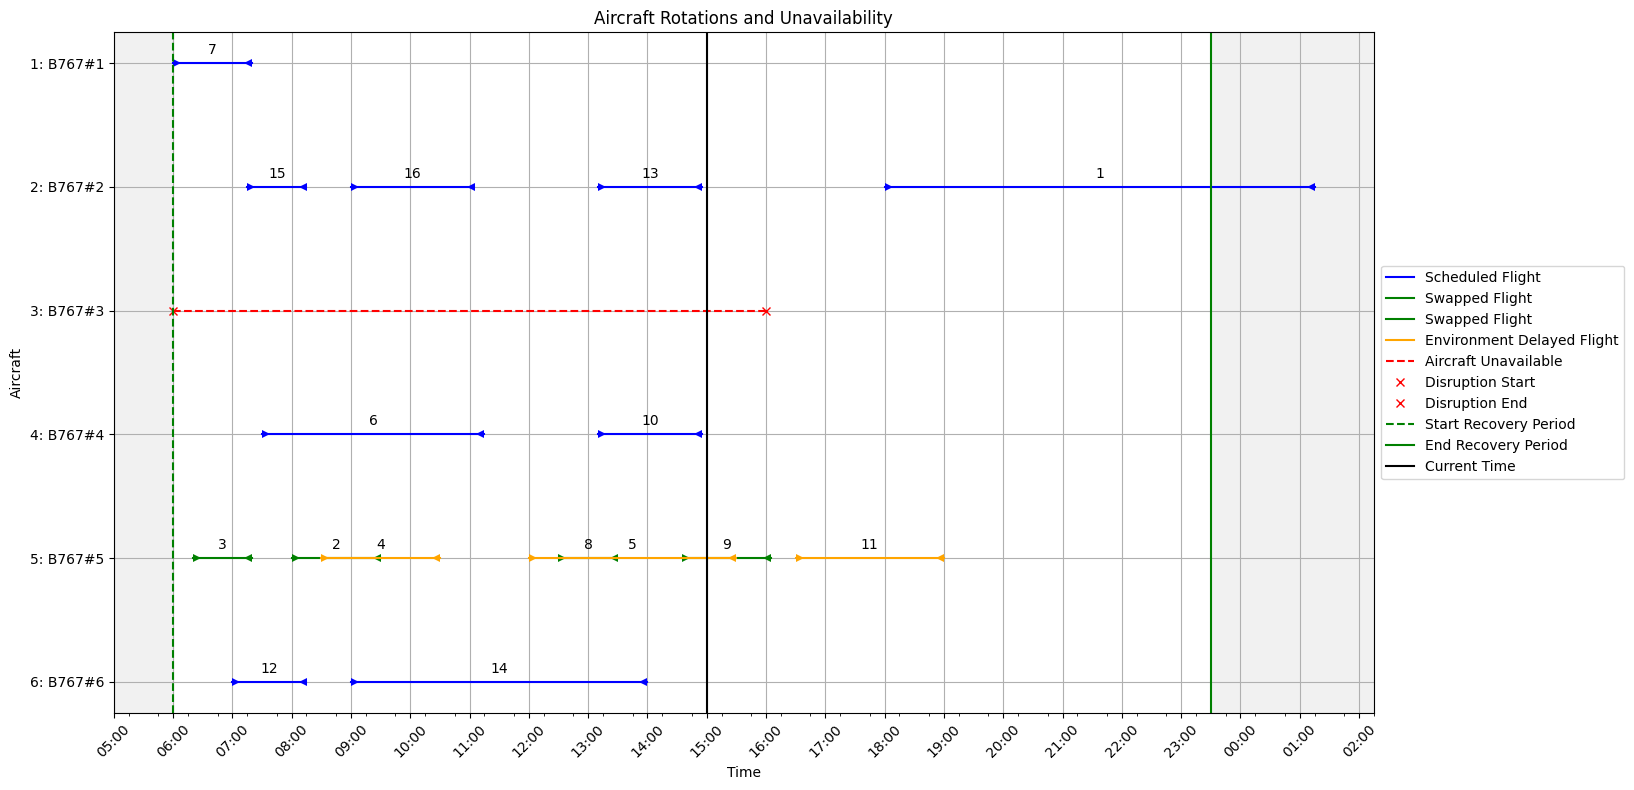

Action taken: [5], Reward: [0.]
Step 10:


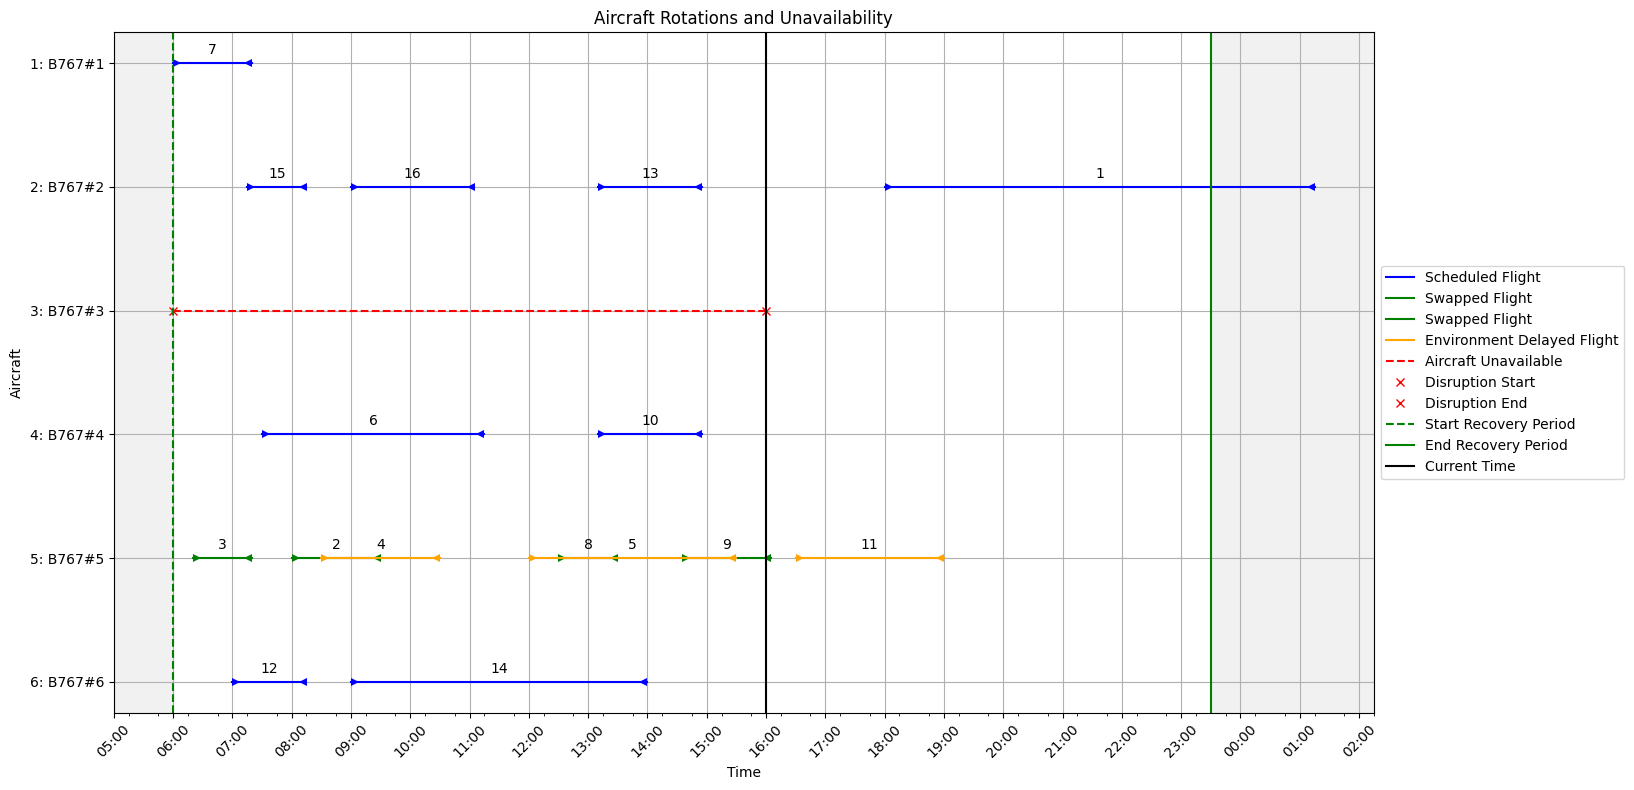

Action taken: [5], Reward: [0.]
Step 11:


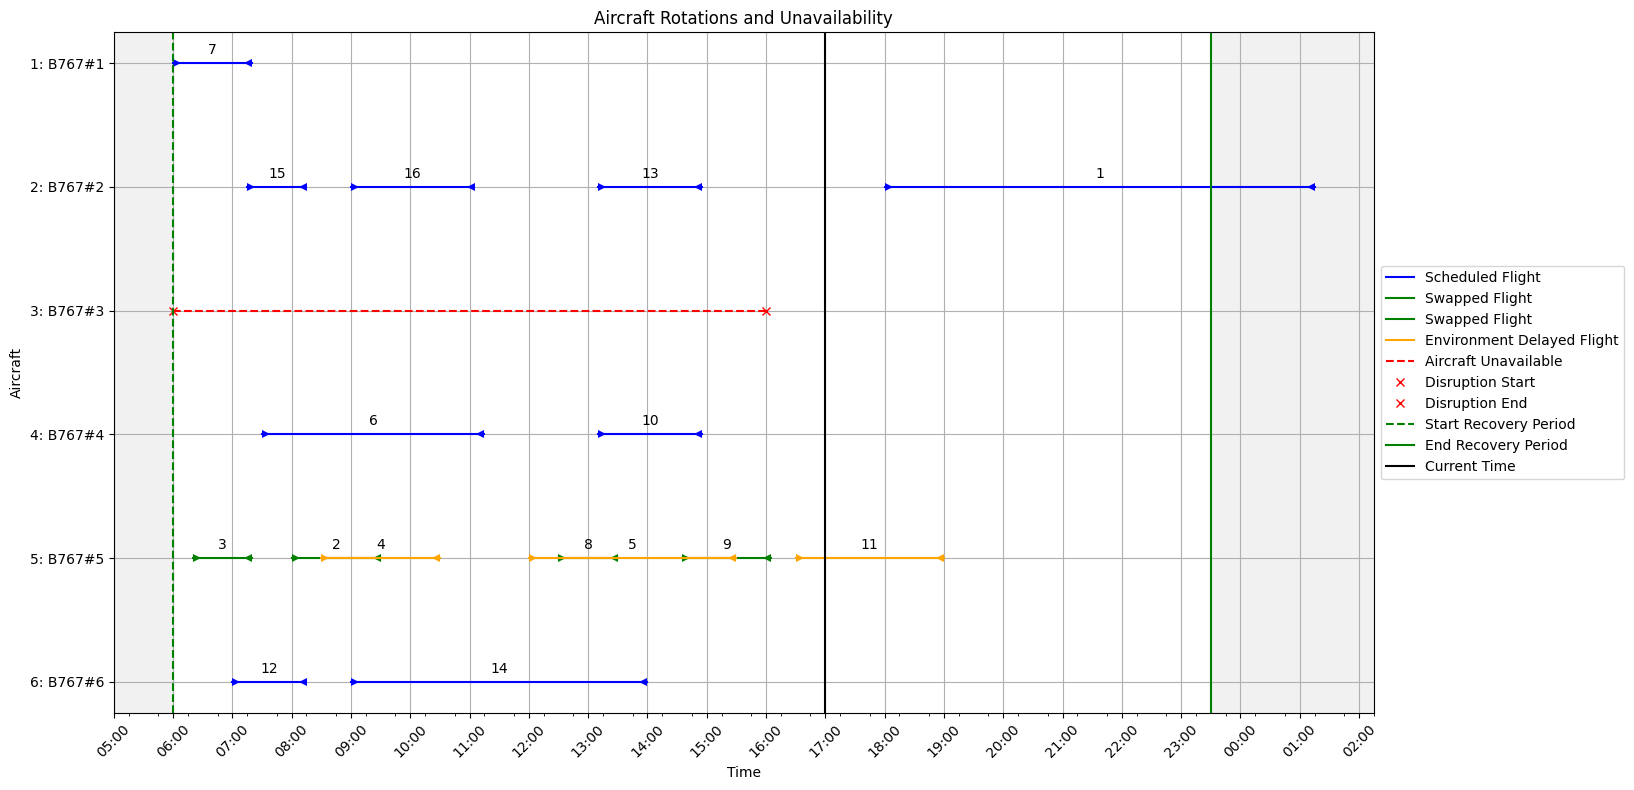

Action taken: [5], Reward: [0.]
Step 12:


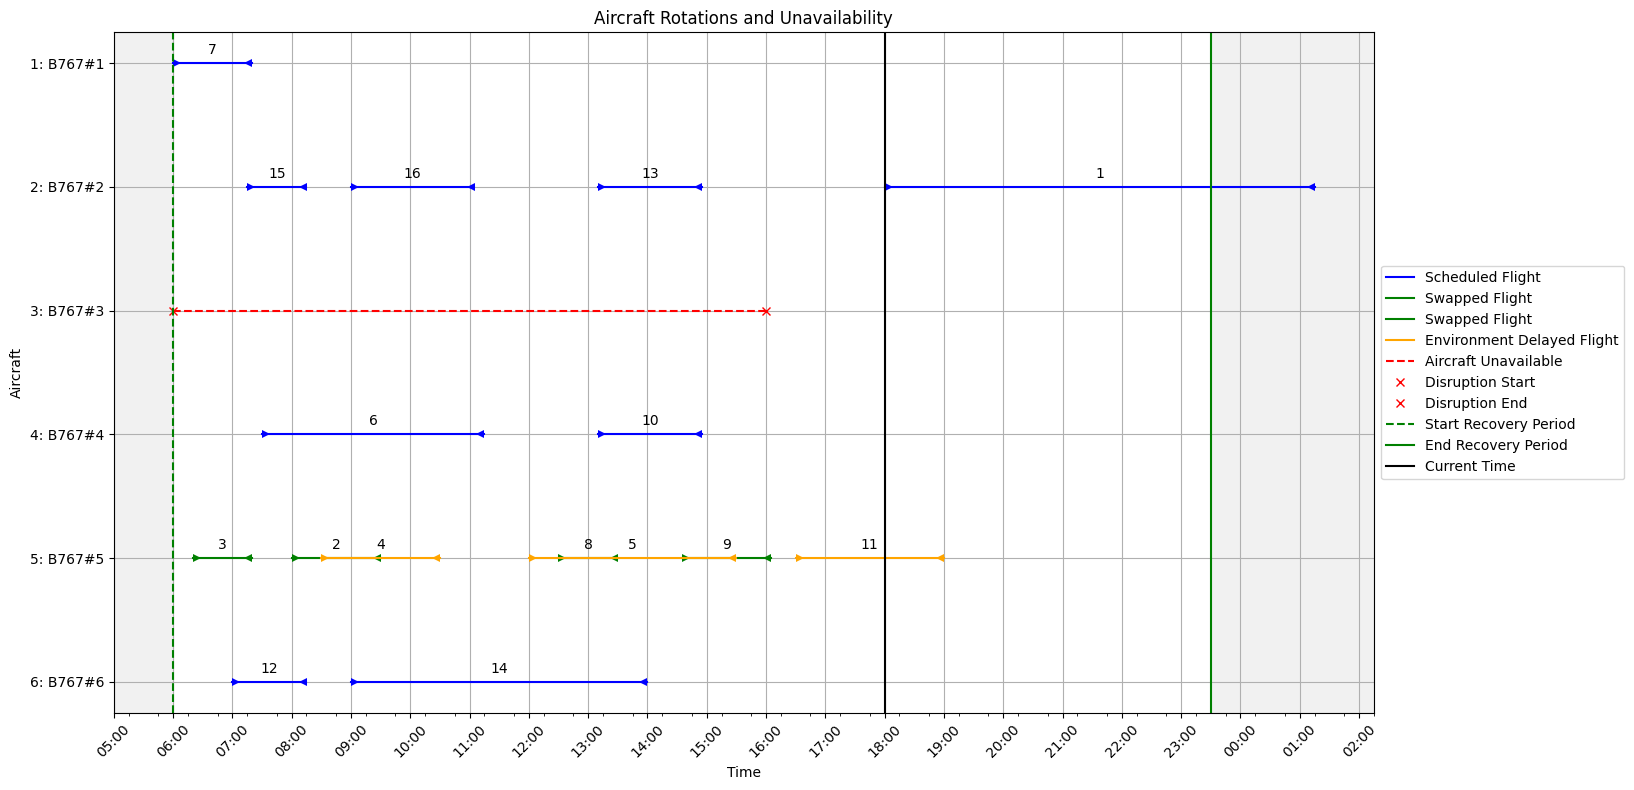

Action taken: [5], Reward: [0.]
Step 13:


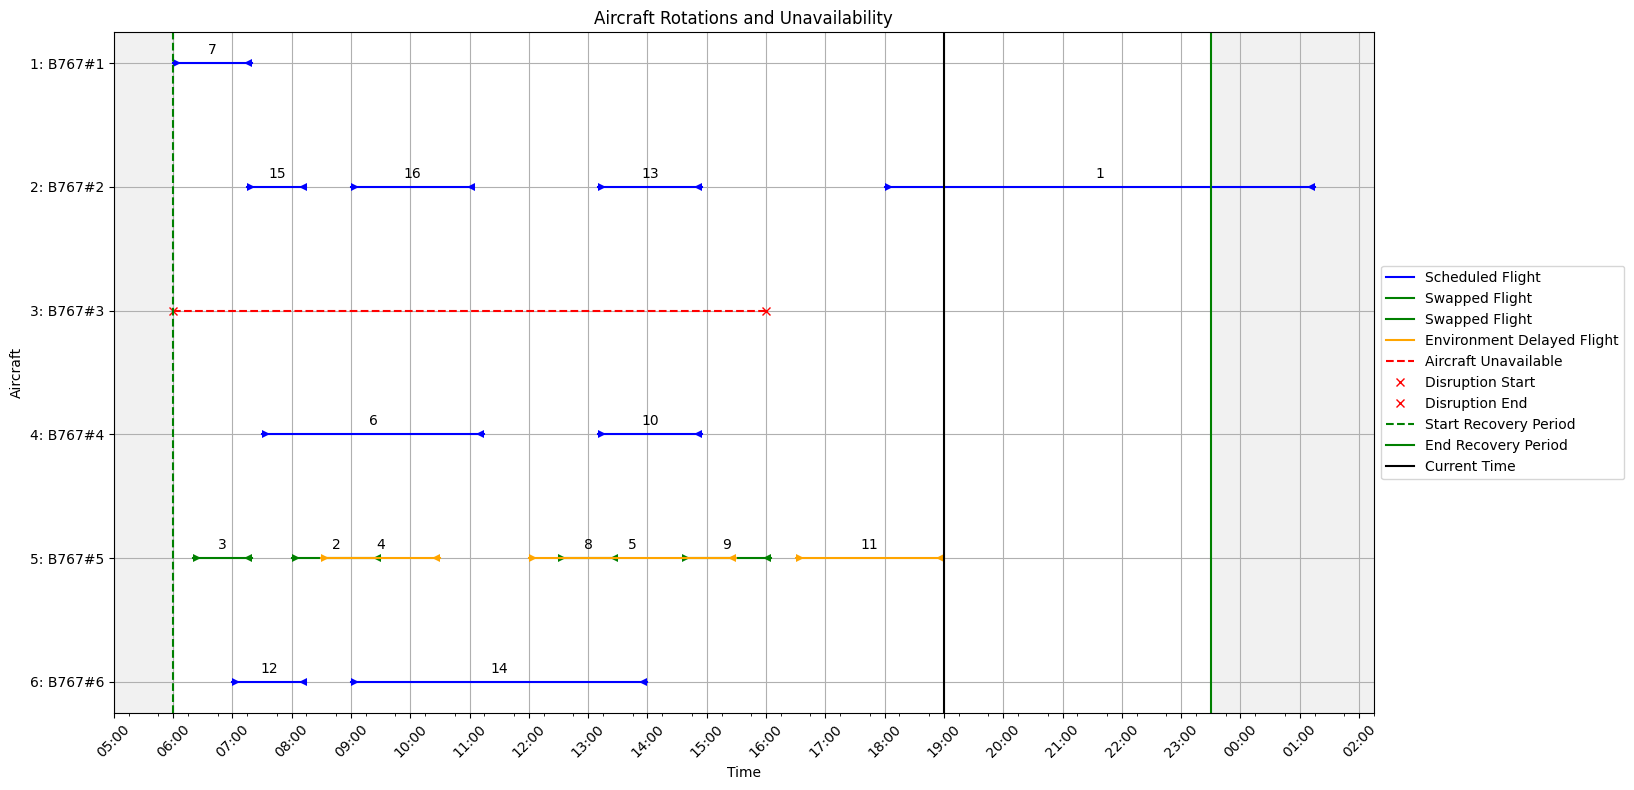

Action taken: [5], Reward: [0.]
Step 14:


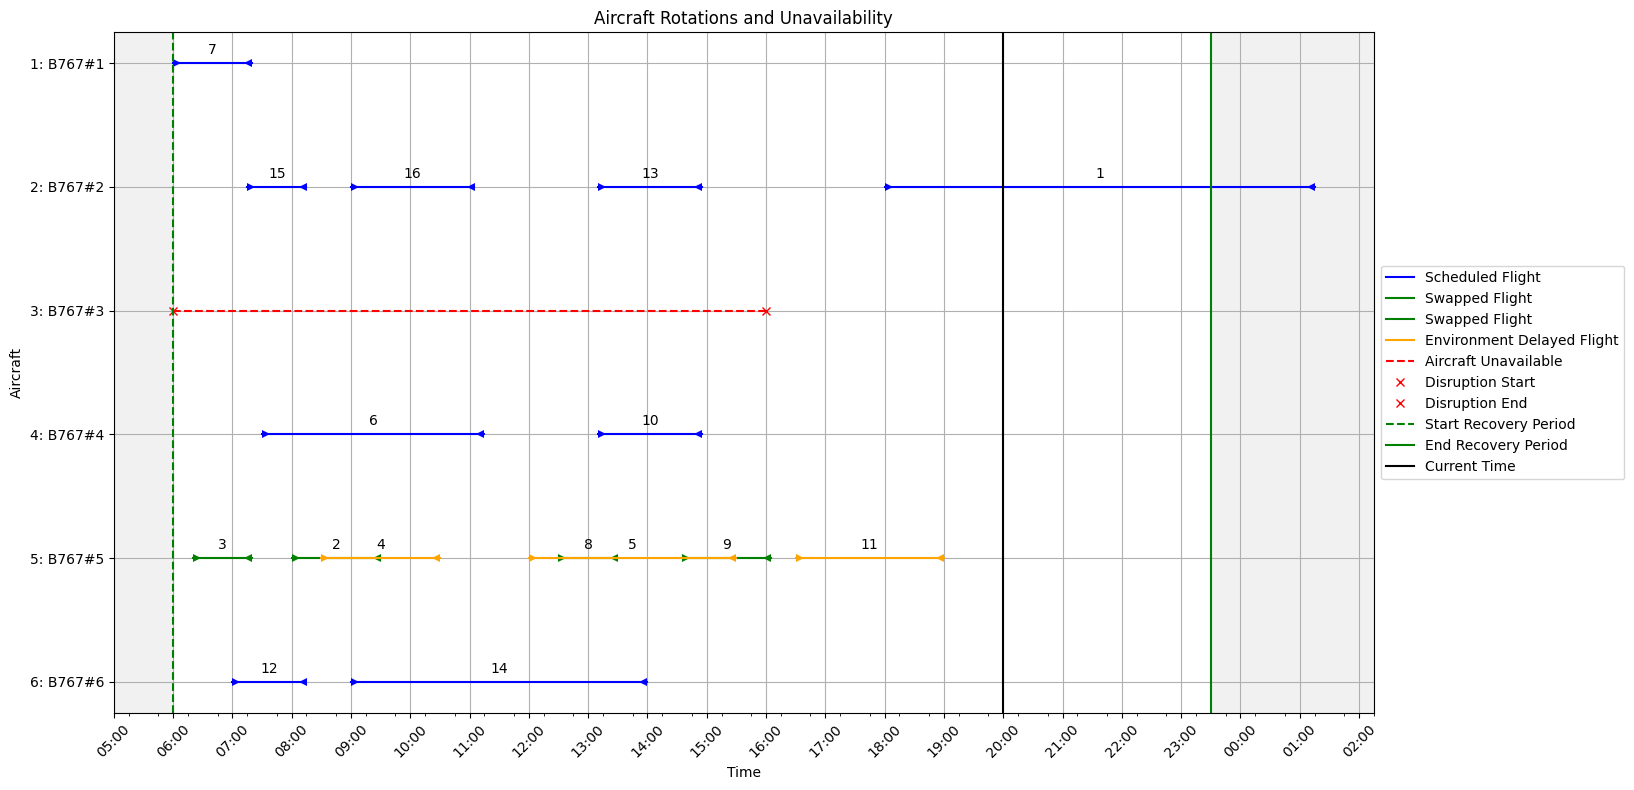

Action taken: [5], Reward: [0.]
Step 15:


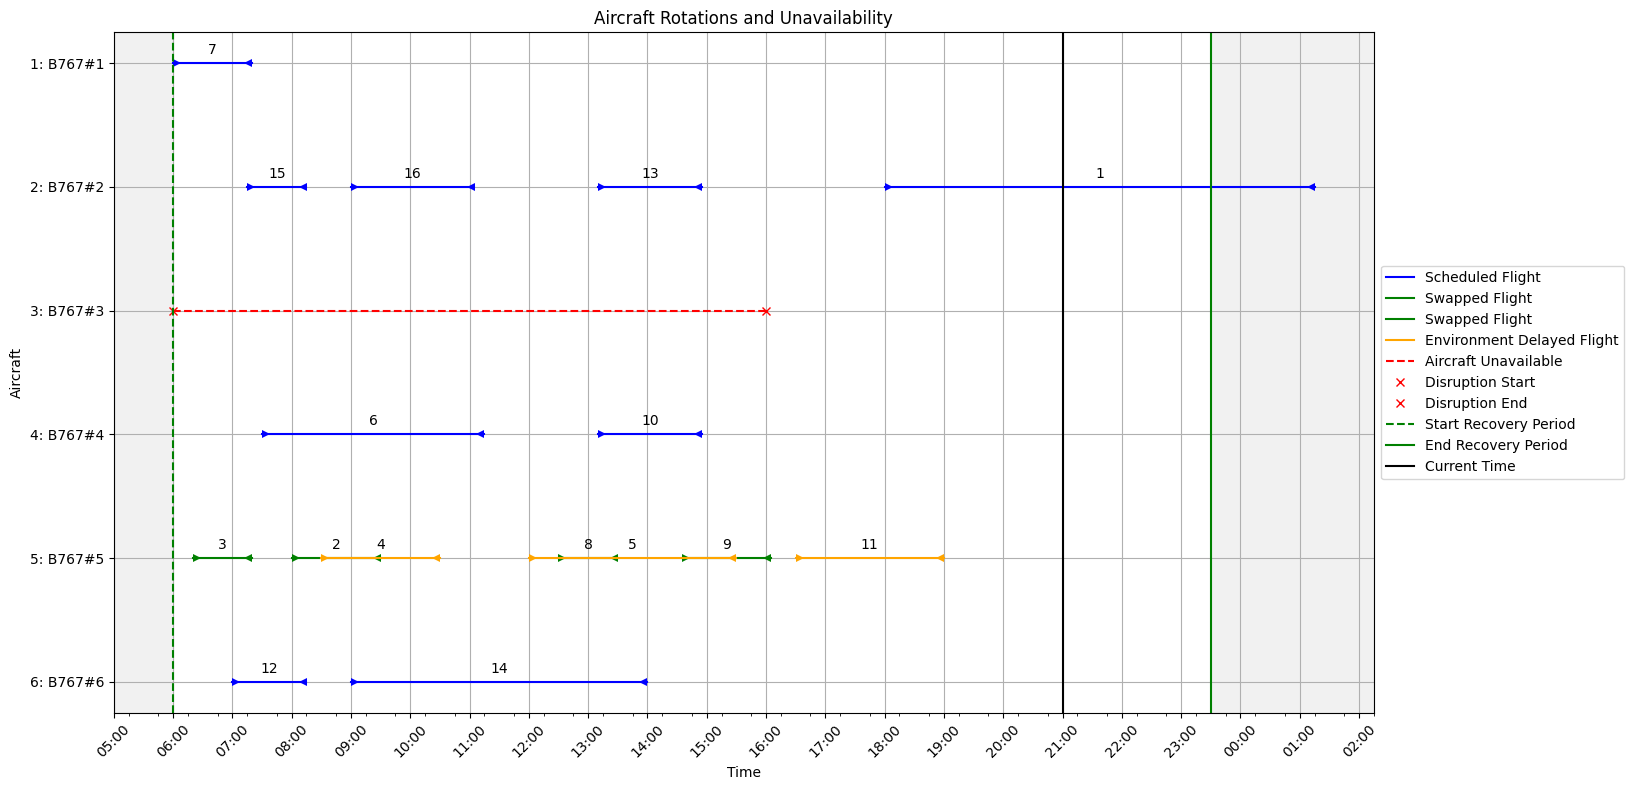

Action taken: [5], Reward: [0.]
Step 16:


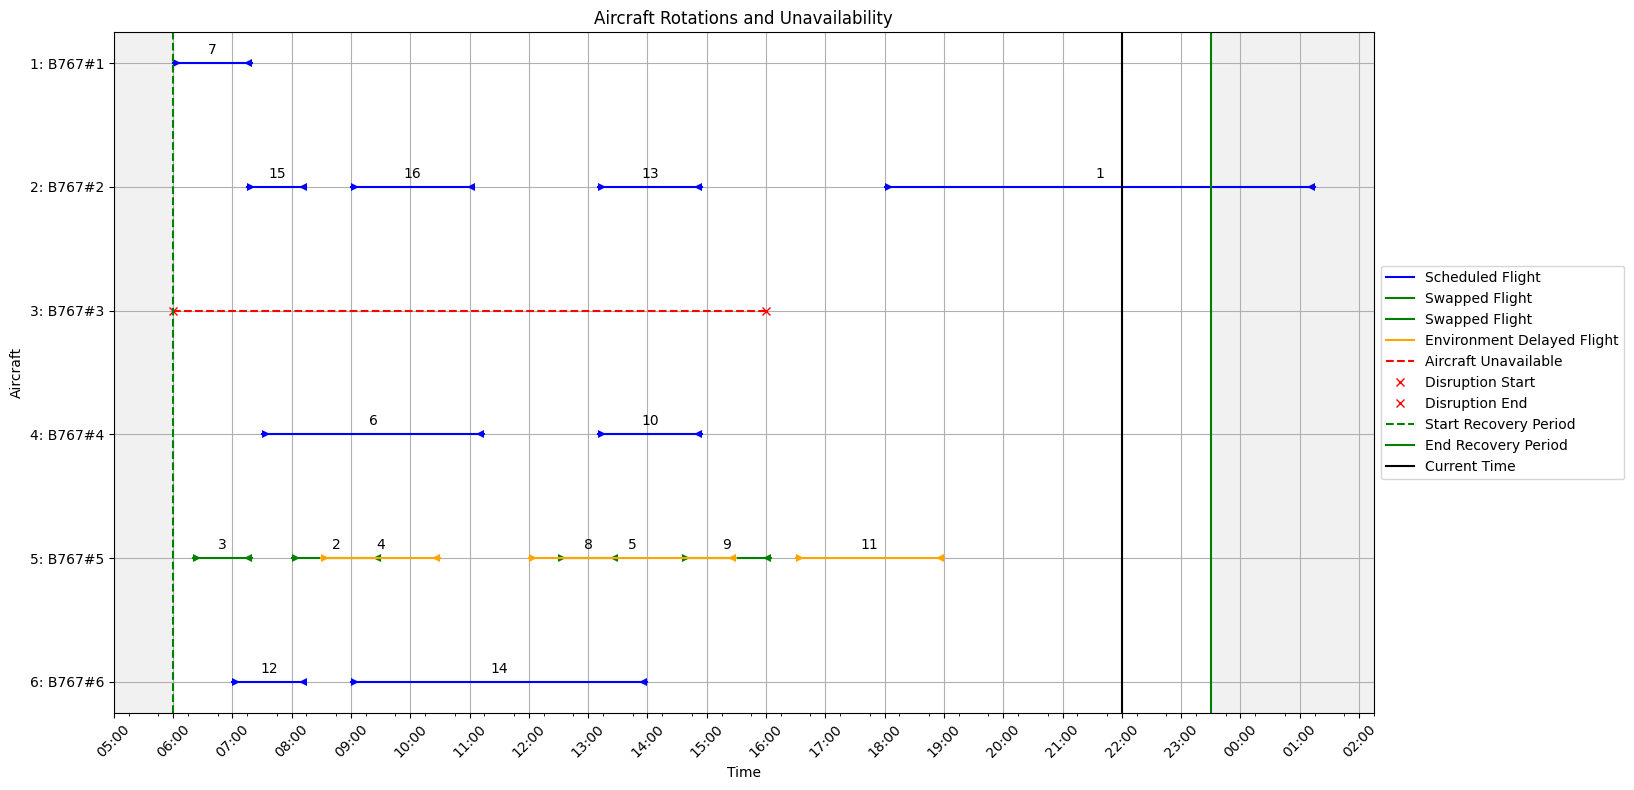

Action taken: [5], Reward: [0.]
Step 17:


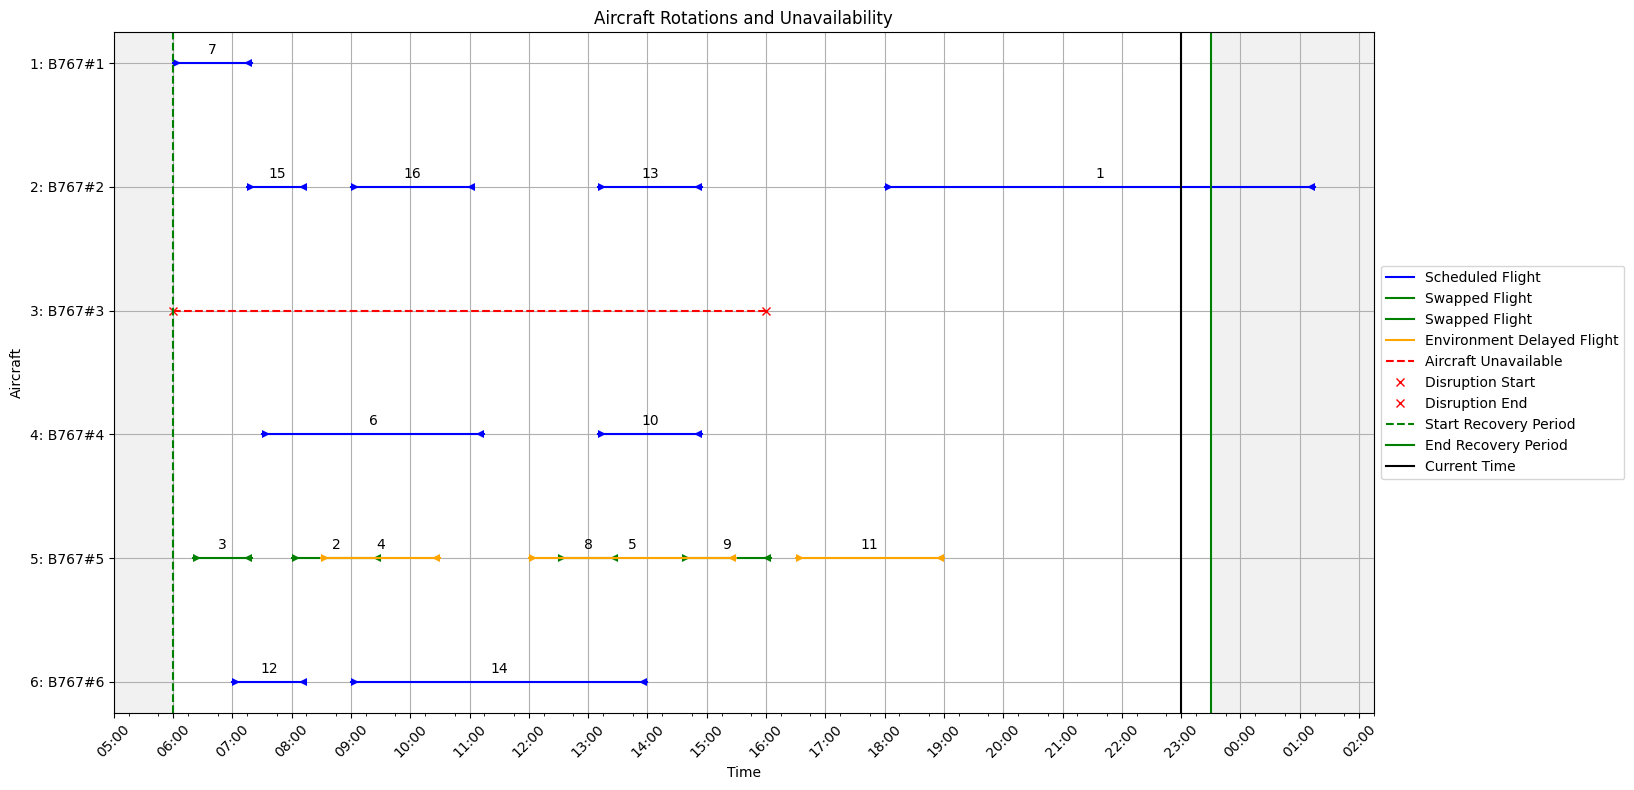

Action taken: [5], Reward: [0.]
Total Reward: [16375.]


In [2]:
import os
import torch as th
import numpy as np
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter



# Load the model and run inference
def run_inference(model_path, scenario_folder):
    # Load the trained model
    model = DQN.load(model_path)

    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
    env = DummyVecEnv([lambda: env])

    # Reset the environment for inference
    obs = env.reset()  # Only one value returned
    if DEBUG_MODE:    
        print("Observation shape:", obs.shape)  # Make sure this prints (1, 11, 23) if using DummyVecEnv
        print("Model observation space shape:", model.observation_space.shape)


    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict, 
        flights_dict=flights_dict, 
        rotations_dict=rotations_dict, 
        alt_aircraft_dict=alt_aircraft_dict,
        start_datetime=env.get_attr('start_datetime')[0],  # Extract from environment
        end_datetime=env.get_attr('end_datetime')[0]       # Extract from environment
    )

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")
        
        # Extract necessary information from the environment for plotting
        swapped_flights = env.get_attr('swapped_flights')[0]
        environment_delayed_flights = env.get_attr('environment_delayed_flights')[0]
        current_datetime = env.get_attr('current_datetime')[0]

        # Use StatePlotter to plot the current state
        state_plotter.plot_state(flights_dict, swapped_flights, environment_delayed_flights, current_datetime)

        # Use the trained model to predict the action
        action = model.predict(obs, deterministic=True)[0]

        # Step the environment
        obs, reward, done, info = env.step(action)

        # Accumulate the reward
        total_reward += reward

        print(f"Action taken: {action}, Reward: {reward}")

        step_num += 1

    print(f"Total Reward: {total_reward}")

# Specify the model path and the scenario folder you want to infer
# ask the user for input dropdown of the zip files inside the Models folder
MODEL_PATH = "../trained_models/dqn_3000d_10u-9.zip"

SCENARIO_FOLDER = "../data/Example/Busy-scenario"  # Path to the new scenario for inference

# Verify folder and model exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# Run inference
run_inference(MODEL_PATH, SCENARIO_FOLDER)
